In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [3]:
df = pd.read_csv("../../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

df = scaled_data(df)

seq_len = 15
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

/Users/sohamsamal/Documents/Coding/Research/research-btc-pred/venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

In [5]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters=32, num_bilstm_layers=2, lstm_hidden=64, filter_size=(10, 1), input_lstm_dim=100, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=num_filters,
            kernel_size=filter_size[0],
            stride=1,
            padding=filter_size[0] // 2
        )

        self.proj = nn.Linear(num_filters, input_lstm_dim)

        self.relu = nn.ReLU()

        self.bilstm1 = nn.LSTM(
            input_size=input_lstm_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.drop1 = nn.Dropout(dropout_rate)

        self.bilstm2 = nn.LSTM(
            input_size = 2 * lstm_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(lstm_hidden * 2, 1)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))

        x = x.permute(0, 2, 1)
        x = self.relu(self.proj(x))

        # BiLSTM layers
        out, _ = self.bilstm1(x)
        out = self.drop1(out)
        out, _ = self.bilstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [7]:
model = CNNBiLSTM(input_dim=len(features))

In [8]:
decay_rate = 0.8
num_epochs = 500
learning_rate = 0.001
l2_penalty = 0.001

In [9]:
# Training the model using the train_loader, val_loader, and test_loader
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

num_epochs = 300
best_val_loss = float('inf')
patience = 30
patience_counter = 0

# Load existing model's best validation loss if it exists
existing_model_path = '../../models/final_models/cnn_bilstm15.pth'
existing_best_val_loss = float('inf')

if os.path.exists(existing_model_path):
    try:
        temp_model = CNNBiLSTM(input_dim=len(features))
        temp_model = temp_model.to(device)
        temp_model.load_state_dict(torch.load(existing_model_path))
        temp_model.eval()
        test_loss = 0.0
        test_predictions = []
        test_targets = []

        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                outputs = temp_model(batch_x)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()

                test_predictions.extend(outputs.cpu().numpy())
                test_targets.extend(batch_y.cpu().numpy())

        existing_best_val_loss = test_loss / len(test_loader)
        print(f'Test Loss: {existing_best_val_loss:.6f}')

    except Exception as e:
        print(f"Could not load existing model: {e}")
        existing_best_val_loss = float('inf')

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break




# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# After training is complete, compare with existing model and save only if better
if avg_test_loss < existing_best_val_loss:
    torch.save(model.state_dict(), existing_model_path)
    print(f'\nNew model is better! Saved with test loss: {avg_test_loss:.6f}')
    print(f'Previous best was: {existing_best_val_loss:.6f}')
else:
    print(f'\nExisting model is better. Not saving new model.')
    print(f'New model test loss: {avg_test_loss:.6f}')
    print(f'Existing model validation loss: {existing_best_val_loss:.6f}')

print(f'\nBest test loss achieved this training: {avg_test_loss:.6f}')

Test Loss: 0.143545
Training on device: mps
Model parameters: 192261
Epoch 1/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 38.21it/s]


Epoch [1/300] - Train Loss: 1.300539, Val Loss: 19.713286
Epoch 2/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 171.96it/s]


Epoch [2/300] - Train Loss: 1.096408, Val Loss: 18.105462
Epoch 3/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 172.89it/s]


Epoch [3/300] - Train Loss: 0.863671, Val Loss: 15.288408
Epoch 4/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 180.77it/s]


Epoch [4/300] - Train Loss: 0.648700, Val Loss: 11.195829
Epoch 5/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.68it/s]


Epoch [5/300] - Train Loss: 0.461845, Val Loss: 6.724826
Epoch 6/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 178.87it/s]


Epoch [6/300] - Train Loss: 0.288904, Val Loss: 3.988164
Epoch 7/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.43it/s]


Epoch [7/300] - Train Loss: 0.145440, Val Loss: 2.208660
Epoch 8/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.40it/s]


Epoch [8/300] - Train Loss: 0.078582, Val Loss: 0.528709
Epoch 9/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 169.06it/s]


Epoch [9/300] - Train Loss: 0.062736, Val Loss: 0.503911
Epoch 10/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 152.40it/s]


Epoch [10/300] - Train Loss: 0.077882, Val Loss: 0.707301
Epoch 11/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 131.40it/s]


Epoch [11/300] - Train Loss: 0.080572, Val Loss: 0.423634
Epoch 12/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 51.71it/s]


Epoch [12/300] - Train Loss: 0.055809, Val Loss: 0.829408
Epoch 13/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 106.68it/s]


Epoch [13/300] - Train Loss: 0.028833, Val Loss: 0.310654
Epoch 14/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 154.66it/s]


Epoch [14/300] - Train Loss: 0.025415, Val Loss: 0.304255
Epoch 15/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 173.55it/s]


Epoch [15/300] - Train Loss: 0.021268, Val Loss: 0.523239
Epoch 16/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.13it/s]


Epoch [16/300] - Train Loss: 0.019744, Val Loss: 0.338481
Epoch 17/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 169.01it/s]


Epoch [17/300] - Train Loss: 0.029549, Val Loss: 1.054980
Epoch 18/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 87.97it/s]


Epoch [18/300] - Train Loss: 0.031944, Val Loss: 0.276456
Epoch 19/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 120.84it/s]


Epoch [19/300] - Train Loss: 0.040890, Val Loss: 1.412920
Epoch 20/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 139.65it/s]


Epoch [20/300] - Train Loss: 0.021816, Val Loss: 0.371765
Epoch 21/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 98.77it/s]


Epoch [21/300] - Train Loss: 0.014434, Val Loss: 0.811192
Epoch 22/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 130.07it/s]


Epoch [22/300] - Train Loss: 0.011832, Val Loss: 0.640363
Epoch 23/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 171.61it/s]


Epoch [23/300] - Train Loss: 0.010281, Val Loss: 0.652085
Epoch 24/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 168.61it/s]


Epoch [24/300] - Train Loss: 0.009149, Val Loss: 0.840845
Epoch 25/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 115.13it/s]


Epoch [25/300] - Train Loss: 0.010173, Val Loss: 0.636316
Epoch 26/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 103.81it/s]


Epoch [26/300] - Train Loss: 0.013108, Val Loss: 1.031855
Epoch 27/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 126.42it/s]


Epoch [27/300] - Train Loss: 0.025333, Val Loss: 0.441213
Epoch 28/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 39.67it/s]


Epoch [28/300] - Train Loss: 0.063557, Val Loss: 2.049822
Epoch 29/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 106.13it/s]


Epoch [29/300] - Train Loss: 0.071802, Val Loss: 0.216756
Epoch 30/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 76.43it/s]


Epoch [30/300] - Train Loss: 0.041917, Val Loss: 1.637279
Epoch 31/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 118.03it/s]


Epoch [31/300] - Train Loss: 0.013765, Val Loss: 0.552821
Epoch 32/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 169.90it/s]


Epoch [32/300] - Train Loss: 0.013037, Val Loss: 0.684717
Epoch 33/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 117.21it/s]


Epoch [33/300] - Train Loss: 0.012356, Val Loss: 0.985011
Epoch 34/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 103.09it/s]


Epoch [34/300] - Train Loss: 0.009255, Val Loss: 0.733544
Epoch 35/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 84.18it/s]


Epoch [35/300] - Train Loss: 0.008493, Val Loss: 0.945107
Epoch 36/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 116.49it/s]


Epoch [36/300] - Train Loss: 0.007667, Val Loss: 0.950584
Epoch 37/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 161.08it/s]


Epoch [37/300] - Train Loss: 0.007234, Val Loss: 0.867344
Epoch 38/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 149.17it/s]


Epoch [38/300] - Train Loss: 0.006204, Val Loss: 0.882412
Epoch 39/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 42.38it/s]


Epoch [39/300] - Train Loss: 0.006056, Val Loss: 0.881482
Epoch 40/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 108.14it/s]


Epoch [40/300] - Train Loss: 0.006657, Val Loss: 0.883006
Epoch 41/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 164.09it/s]


Epoch [41/300] - Train Loss: 0.006059, Val Loss: 0.711397
Epoch 42/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 86.43it/s]


Epoch [42/300] - Train Loss: 0.008508, Val Loss: 1.048167
Epoch 43/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 102.73it/s]


Epoch [43/300] - Train Loss: 0.015892, Val Loss: 0.486519
Epoch 44/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 44.03it/s]


Epoch [44/300] - Train Loss: 0.040453, Val Loss: 1.811442
Epoch 45/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 166.17it/s]


Epoch [45/300] - Train Loss: 0.050571, Val Loss: 0.204071
Epoch 46/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 133.80it/s]


Epoch [46/300] - Train Loss: 0.039276, Val Loss: 1.784803
Epoch 47/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 159.34it/s]


Epoch [47/300] - Train Loss: 0.016898, Val Loss: 0.431214
Epoch 48/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 78.15it/s]


Epoch [48/300] - Train Loss: 0.008121, Val Loss: 1.002523
Epoch 49/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 165.90it/s]


Epoch [49/300] - Train Loss: 0.008847, Val Loss: 0.938389
Epoch 50/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 97.83it/s]


Epoch [50/300] - Train Loss: 0.007844, Val Loss: 0.749932
Epoch 51/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 33.48it/s]


Epoch [51/300] - Train Loss: 0.007068, Val Loss: 0.943607
Epoch 52/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 151.48it/s]


Epoch [52/300] - Train Loss: 0.005858, Val Loss: 0.903383
Epoch 53/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 159.36it/s]


Epoch [53/300] - Train Loss: 0.006209, Val Loss: 0.860745
Epoch 54/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 121.28it/s]


Epoch [54/300] - Train Loss: 0.005599, Val Loss: 0.933782
Epoch 55/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 162.93it/s]


Epoch [55/300] - Train Loss: 0.005570, Val Loss: 0.823835
Epoch 56/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 97.21it/s]


Epoch [56/300] - Train Loss: 0.005612, Val Loss: 1.005817
Epoch 57/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 115.33it/s]


Epoch [57/300] - Train Loss: 0.007286, Val Loss: 0.679467
Epoch 58/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 176.46it/s]


Epoch [58/300] - Train Loss: 0.009973, Val Loss: 1.252552
Epoch 59/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 169.75it/s]


Epoch [59/300] - Train Loss: 0.013595, Val Loss: 0.468036
Epoch 60/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 168.08it/s]


Epoch [60/300] - Train Loss: 0.019856, Val Loss: 1.547283
Epoch 61/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 164.41it/s]


Epoch [61/300] - Train Loss: 0.020603, Val Loss: 0.360240
Epoch 62/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 175.53it/s]


Epoch [62/300] - Train Loss: 0.021099, Val Loss: 1.578186
Epoch 63/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 55.74it/s]


Epoch [63/300] - Train Loss: 0.017413, Val Loss: 0.391641
Epoch 64/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 33.29it/s]


Epoch [64/300] - Train Loss: 0.013319, Val Loss: 1.319061
Epoch 65/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 62.05it/s]


Epoch [65/300] - Train Loss: 0.009581, Val Loss: 0.554364
Epoch 66/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 31.62it/s]


Epoch [66/300] - Train Loss: 0.005865, Val Loss: 0.996728
Epoch 67/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 168.81it/s]


Epoch [67/300] - Train Loss: 0.005830, Val Loss: 0.757341
Epoch 68/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 93.87it/s]


Epoch [68/300] - Train Loss: 0.004709, Val Loss: 0.938097
Epoch 69/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 139.30it/s]


Epoch [69/300] - Train Loss: 0.005096, Val Loss: 0.769303
Epoch 70/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 163.48it/s]


Epoch [70/300] - Train Loss: 0.004769, Val Loss: 0.974603
Epoch 71/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 100.56it/s]


Epoch [71/300] - Train Loss: 0.004753, Val Loss: 0.709394
Epoch 72/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 114.55it/s]


Epoch [72/300] - Train Loss: 0.005961, Val Loss: 1.006783
Epoch 73/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 168.84it/s]


Epoch [73/300] - Train Loss: 0.007909, Val Loss: 0.616401
Epoch 74/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.85it/s]


Epoch [74/300] - Train Loss: 0.014400, Val Loss: 1.387579
Epoch 75/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 173.42it/s]


Epoch [75/300] - Train Loss: 0.019308, Val Loss: 0.339776
Early stopping triggered after epoch 75
Test Loss: 0.135696

New model is better! Saved with test loss: 0.135696
Previous best was: 0.143545

Best test loss achieved this training: 0.135696


In [10]:
model.load_state_dict(torch.load(existing_model_path))

<All keys matched successfully>

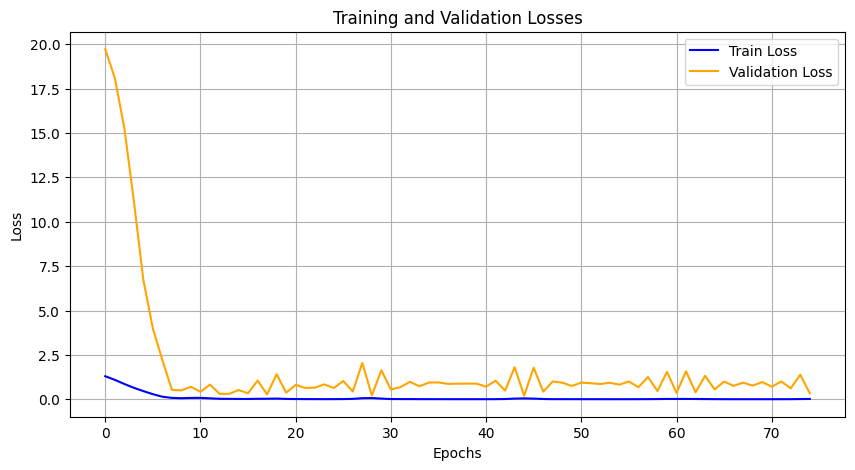

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [12]:
# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.135696


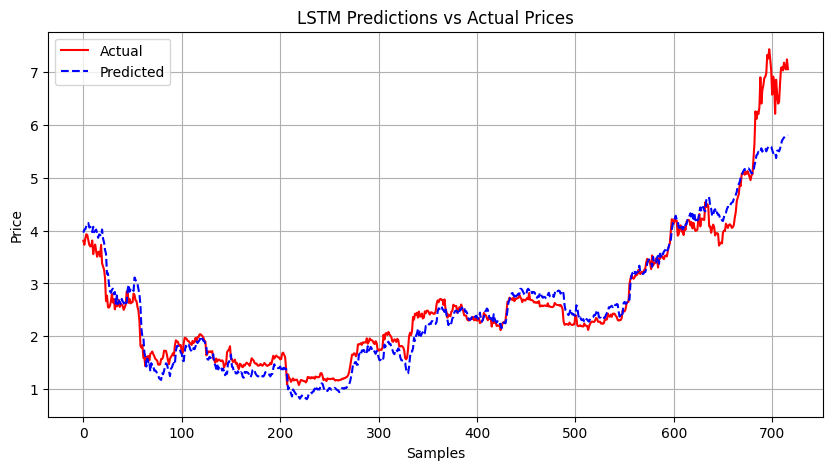

In [13]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()